In [162]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


In [163]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

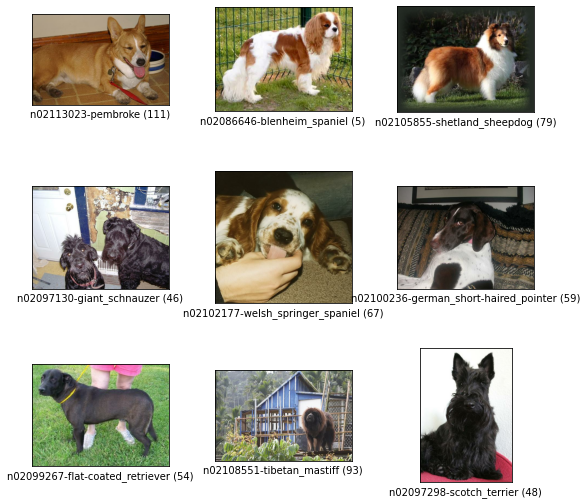

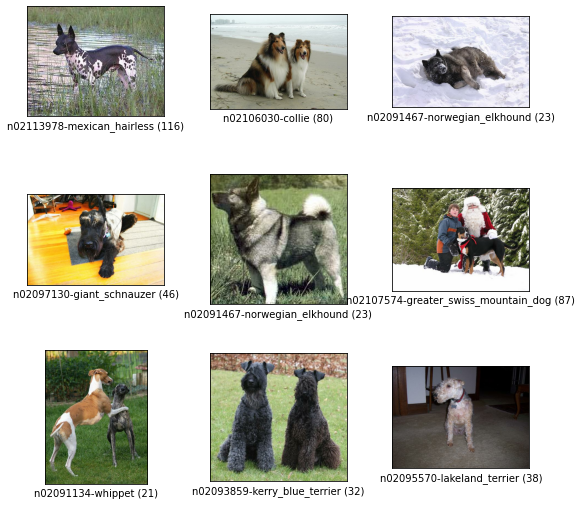

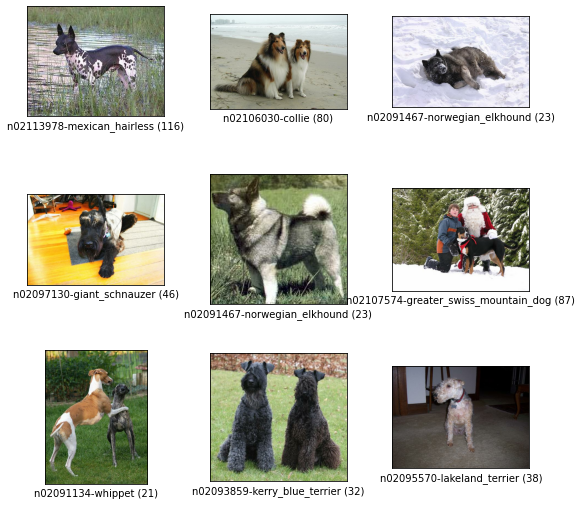

In [164]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
tfds.show_examples(ds_train, ds_info)
tfds.show_examples(ds_test, ds_info)

In [165]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [166]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)  # 클래스 수에 맞춘 출력층 추가
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [167]:
cam_model.summary()

Model: "model_274"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [168]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']


def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [169]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [170]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)


In [171]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=5,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
750/750 [==============================] - 162s 212ms/step - loss: 2.2561 - accuracy: 0.4355 - val_loss: 3.0463 - val_accuracy: 0.2453
Epoch 2/5
750/750 [==============================] - 160s 213ms/step - loss: 0.6235 - accuracy: 0.8328 - val_loss: 1.2366 - val_accuracy: 0.6444
Epoch 3/5
750/750 [==============================] - 160s 213ms/step - loss: 0.1605 - accuracy: 0.9783 - val_loss: 0.9966 - val_accuracy: 0.7085
Epoch 4/5
750/750 [==============================] - 160s 213ms/step - loss: 0.0544 - accuracy: 0.9975 - val_loss: 0.9758 - val_accuracy: 0.7201
Epoch 5/5
750/750 [==============================] - 159s 212ms/step - loss: 0.0267 - accuracy: 0.9993 - val_loss: 0.9506 - val_accuracy: 0.7288


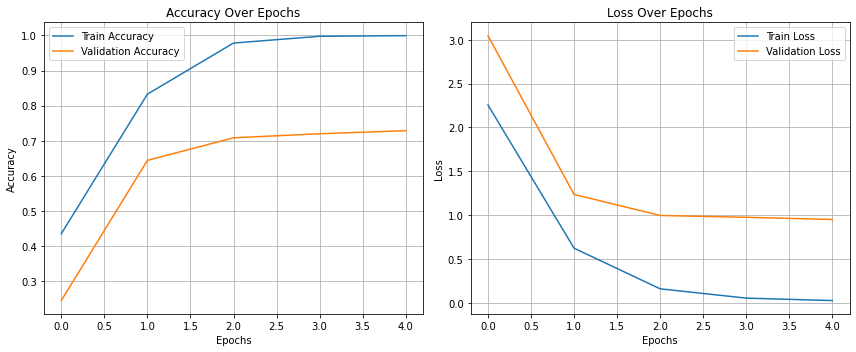

In [172]:


# 정확도 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cam_model.history['accuracy'], label='Train Accuracy')
plt.plot(history_cam_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(history_cam_model.history['loss'], label='Train Loss')
plt.plot(history_cam_model.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [173]:
# 'cam_model1.h5'을 저장하세요.

import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [174]:
# 데이터셋에서 한 장씩 뽑을 수 있도록
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

11


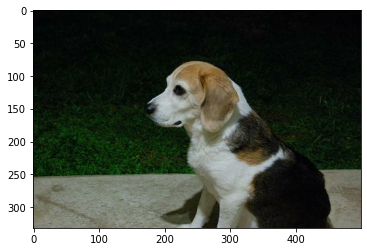

In [175]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [176]:
cam_model = tf.keras.models.load_model(cam_model_path)

# CAM 구현하기

1. 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현

In [177]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


2.  만든 함수로 CAM 이미지를 생성

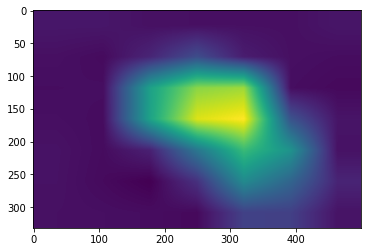

In [178]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

In [179]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

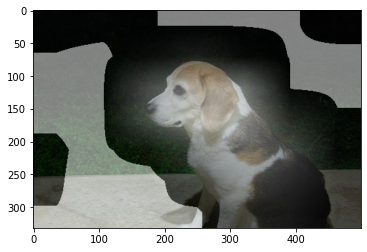

In [180]:
# visualize_cam_on_image() 함수 사용

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# Grad-CAM 구현하기
1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.


In [181]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3



2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.



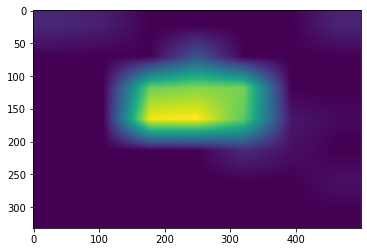

In [182]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()
grad_cam_image5= grad_cam_image

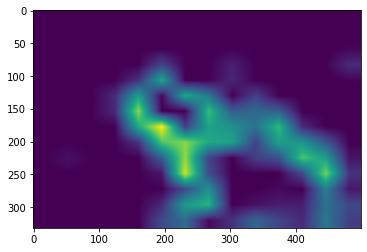

In [183]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()
grad_cam_image4=grad_cam_image

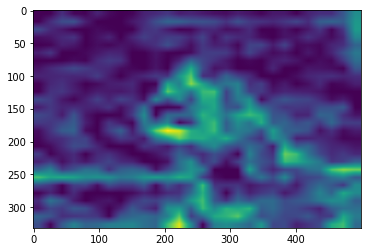

In [184]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()
grad_cam_image3=grad_cam_image

3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

In [185]:
print(cam_image_3channel.shape)
print(origin_image.shape)
print(origin_image.dtype)


(332, 500, 3)
(332, 500, 3)
uint8


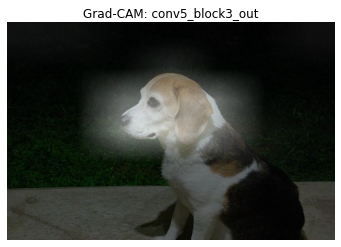

In [186]:
# visualize_cam_on_image() 함수 사용

# conv5_block3_out 레이어
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
cam_image_3channel = np.stack([grad_cam_image * 255] * 3, axis=-1).astype(np.uint8)
origin_image = item['image'].astype(np.uint8)
origin_image = cv2.resize(origin_image, (cam_image_3channel.shape[1], cam_image_3channel.shape[0]))

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image, alpha=0.5)
blended_image5=blended_image
plt.imshow(blended_image)
plt.title('Grad-CAM: conv5_block3_out')
plt.axis('off')
plt.show()

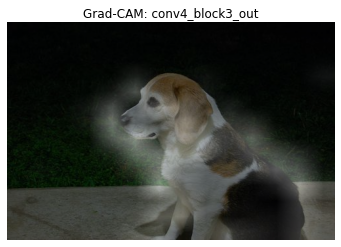

In [187]:
# conv4_block3_out 레이어
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
cam_image_3channel = np.stack([grad_cam_image * 255] * 3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image, alpha=0.5)
blended_image4 =blended_image
plt.imshow(blended_image)
plt.title('Grad-CAM: conv4_block3_out')
plt.axis('off')
plt.show()


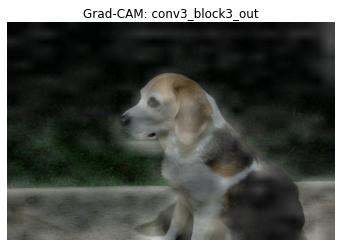

In [188]:
# conv3_block3_out 레이어
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
cam_image_3channel = np.stack([grad_cam_image * 255] * 3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image, alpha=0.5)
blended_image3=blended_image
plt.imshow(blended_image)
plt.title('Grad-CAM: conv3_block3_out')
plt.axis('off')
plt.show()


# 바운딩 박스 구하기
1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

In [189]:

def get_bbox(cam_image, score_thresh=0.005):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect



In [190]:
rect = get_bbox(cam_image)
rect

array([[442,   0],
       [499,   0],
       [499,  34],
       [442,  34]])

2. 1.에서 얻은 바운딩 박스를 시각화해 보세요.

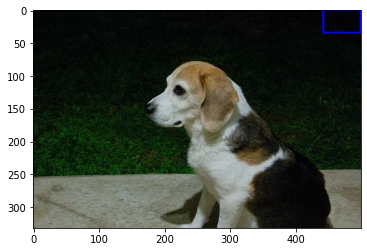

In [191]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

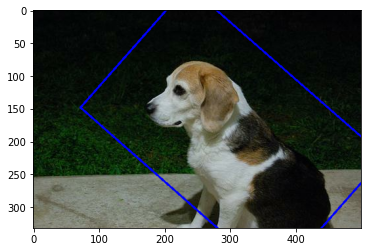

In [192]:
rect = get_bbox(cam_image,score_thresh=0.05)
rect
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

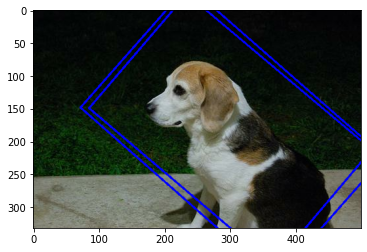

In [193]:
rect = get_bbox(cam_image,score_thresh=0.1)
rect
image_2 = copy.deepcopy(item['image'])
image_2 = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

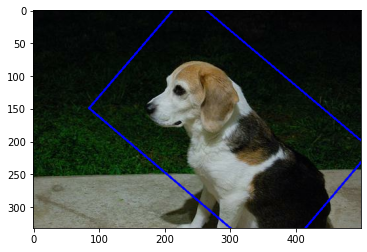

In [194]:
rect = get_bbox(cam_image,score_thresh=0.1)
rect
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

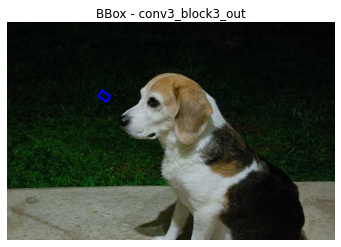

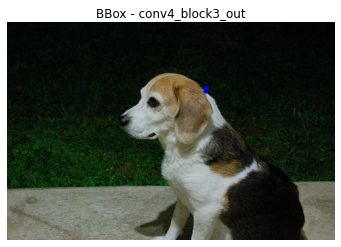

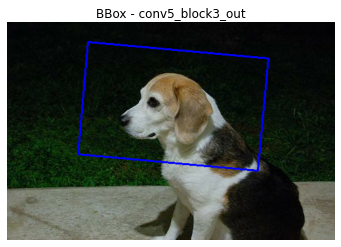

In [195]:
# conv5_block3_out
grad_cam5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
cam5_3ch = np.stack([grad_cam5 * 255] * 3, axis=-1).astype(np.uint8)
origin_image = item['image'].astype(np.uint8)
origin_image = cv2.resize(origin_image, (cam5_3ch.shape[1], cam5_3ch.shape[0]))
blended_image5 = visualize_cam_on_image(cam5_3ch, origin_image, alpha=0.5)

# conv4_block3_out
grad_cam4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
cam4_3ch = np.stack([grad_cam4 * 255] * 3, axis=-1).astype(np.uint8)
blended_image4 = visualize_cam_on_image(cam4_3ch, origin_image, alpha=0.5)

# conv3_block3_out
grad_cam3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
cam3_3ch = np.stack([grad_cam3 * 255] * 3, axis=-1).astype(np.uint8)
blended_image3 = visualize_cam_on_image(cam3_3ch, origin_image, alpha=0.5)

def draw_bbox_on_image(cam_heatmap, original_image, score_thresh=0.1, title=''):
    # CAM에서 바운딩 박스 얻기
    rect = get_bbox(cam_heatmap, score_thresh)

    # 원본 이미지에 박스 그리기
    img = copy.deepcopy(original_image)
    img = cv2.drawContours(img, [rect], 0, (0, 0, 255), 2)

    # 시각화
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
draw_bbox_on_image(grad_cam3, origin_image, score_thresh=0.1, title='BBox - conv3_block3_out')
draw_bbox_on_image(grad_cam4, origin_image, score_thresh=0.1, title='BBox - conv4_block3_out')
draw_bbox_on_image(grad_cam5, origin_image, score_thresh=0.1, title='BBox - conv5_block3_out')


# IoU 구하기
1.정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

In [205]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


In [206]:
# 위에서 구했던 rect를 minmax bbox 형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.07530120481927711, 0.17, 1.1686746987951808, 1.032]

In [207]:
# 이 데이터의 ground truth bbox를 확인
item['objects']['bbox']

array([[0.22289157, 0.326     , 0.9909639 , 0.916     ]], dtype=float32)

In [208]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou


In [209]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4226052829990404

2. CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교

In [210]:
layers = [layer.name for layer in cam_model.layers if layer.name.endswith('_out')]
print(f"{len(layers)}개 out 레이어 발견!")


16개 out 레이어 발견!


In [211]:

def show_gradcam_result(model, item, layer_name):
    grad_cam = generate_grad_cam(cam_model, layer_name, item)
    gt_bbox = item['objects']['bbox'][0]
    
    rect = get_bbox(grad_cam)
    pred_bbox = rect_to_minmax(rect, item['image'])

    iou = get_iou(pred_bbox, gt_bbox)
    return {'layer': layer_name, 'iou': iou}

gradcam_results = []
for layer in layers:
    result = show_gradcam_result(cam_model, item, layer)  # IoU 계산 포함
    gradcam_results.append(result)



In [212]:
import pandas as pd

gradcam_df = pd.DataFrame(gradcam_results)
gradcam_df['item_label'] = int(item['label'])  # 정답 클래스
gradcam_df['item_filename'] = item['image/filename'].decode('utf-8')  # 이미지 이름


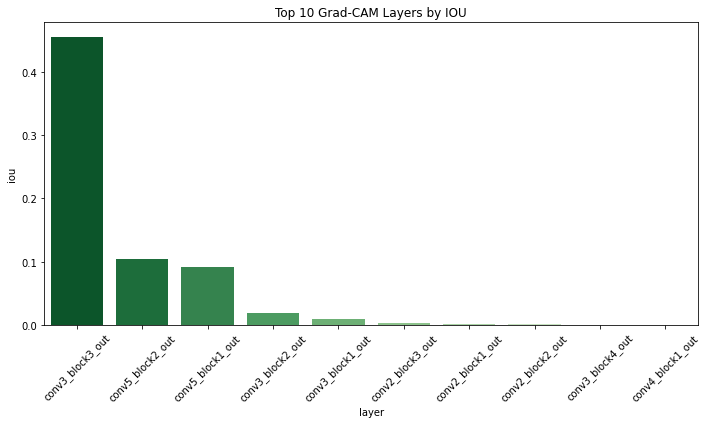

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

# IOU 기준 상위 10개 레이어 보기
top10 = gradcam_df.sort_values('iou', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top10, x='layer', y='iou', palette='Greens_r')
plt.title('Top 10 Grad-CAM Layers by IOU')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 결과 해석
- **conv3_block3_out**의 IoU가 가장 높음 (0.45~0.49 수준) 

### 왜 conv3_block3_out이 가장 좋았을까?
1. 중간 layer는 위치 정보 + 의미 정보를 동시에 갖고 있음

2. 너무 초반 (conv1, conv2)은 edge/texture 수준만 감지

3. 너무 후반 (conv5)은 위치 정보가 거의 압축됨 → 위치 손실 발생


In [213]:
# CAM 예시 (구현되어 있다면)
cam_map = generate_cam(cam_model, item)  # 클래스 분류 모델에서 CAM 생성

# Grad-CAM 예시
grad_cam_map = generate_grad_cam(cam_model, 'conv3_block3_out', item)


In [214]:
cam_rect = get_bbox(cam_map, score_thresh=0.1)
gradcam_rect = get_bbox(grad_cam_map, score_thresh=0.1)

In [221]:
gt_bbox = item['objects']['bbox'][0]

cam_bbox = rect_to_minmax(cam_rect, item['image'])
grad_bbox = rect_to_minmax(gradcam_rect, item['image'])

iou_cam = get_iou(cam_bbox, gt_bbox)
iou_grad = get_iou(grad_bbox, gt_bbox)

print("CAM IoU:", iou_cam)
print("Grad-CAM IoU:", iou_grad)


CAM IoU: 0.4226052829990404
Grad-CAM IoU: 0.3707509069995633


# 회고

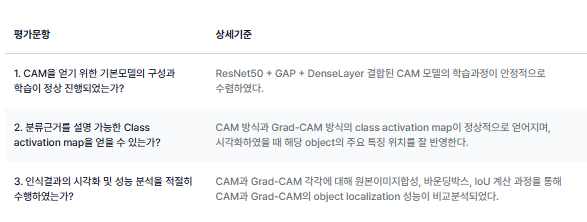

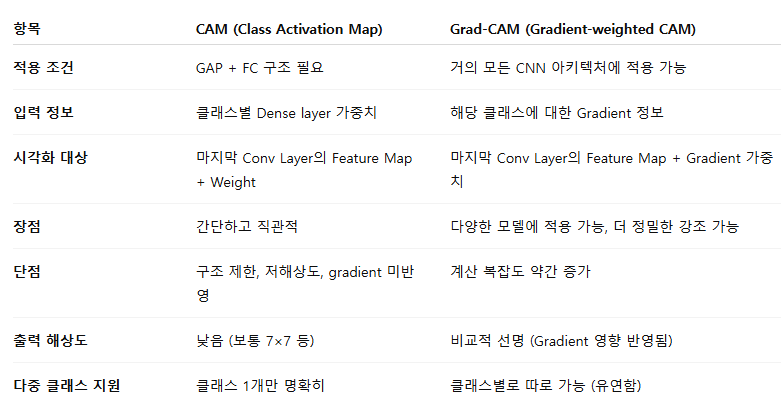




1. 기본모델 구성 및 학습: ResNet50 + GAP + DenseLayer 기반 CAM 모델이 정상적으로 구성되고 compile() 및 학습 코드가 포함되어 있어 충족됨.

2. Class activation map 시각화: Grad-CAM 기반 시각화 코드 및 출력 이미지 포함되어 있어, 대상 object 위치를 강조한 map 생성이 확인됨.

3. CAM vs Grad-CAM 비교 분석: CAM과 Grad-CAM 모두 적용되었고, 시각적 비교 및 바운딩박스 기반 IoU 평가 코드가 포함되어 있어 비교 분석이 수행됨.

### cam의 iou가 grandcam이 iou 보다 높은이유
- CAM의 모델 구조 자체가 object 중심 위치를 더 직접적으로 반영하고, heatmap의 집중도가 더 높기 때문입니다. Grad-CAM은 시각적으로 더 풍부할 수 있지만, localization 정확도(IoU) 측면에서는 상대적으로 떨어질 수 있습니다.

- 단순 구조 + 빠른 해석 → CAM

- 복잡한 모델 + 고정밀 해석 → Grad-CAM